In [ ]:
!pip install transformers
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from difflib import SequenceMatcher
import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image  # potentially
import timm
from urllib.request import urlopen
from PIL import Image

  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.57.1-py3-none-any.whl (12.0 MB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance"""
    return 1 / (1 + np.linalg.norm(np.array(v1) - np.array(v2)))

def cosine_sim(v1, v2):
    """Calculate cosine similarity"""
    return 1 - cosine(v1, v2)

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient"""
    return np.corrcoef(v1, v2)[0, 1]

def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher"""
    return SequenceMatcher(None, str1, str2).ratio()

# Example usage:
# v1 = [1, 2, 3]
# v2 = [4, 5, 6]
# set1 = set([1, 2, 3])
# set2 = set([2, 3, 4])
# str1 = "hello"
# str2 = "hallo"

In [29]:
def plot_tensors_2d(*tensors):
    """
    Takes n tensors of arbitrary dimensionality, flattens them, reduces to 2D using PCA,
    and plots them on a 2D scatter plot.
    """
    # Flatten each tensor into a 1D vector
    flattened = [t.reshape(-1) for t in tensors]
    
    # Stack into a single matrix (n_samples x n_features)
    data = np.stack(flattened)
    
    # Reduce to 2D with PCA
    reduced = PCA(n_components=2).fit_transform(data)
    
    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], s=80)
    for i, (x, y) in enumerate(reduced):
        plt.text(x, y, f'T{i+1}', fontsize=16, ha='center', va='center')
    plt.title("2D Projection of Tensors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(True)
    plt.show()

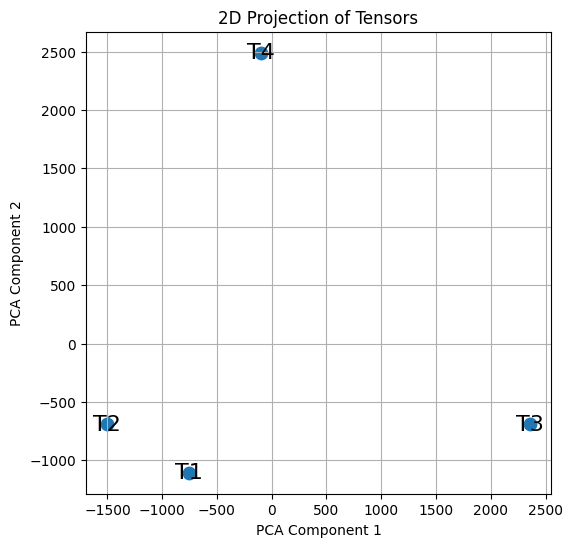

In [30]:
a = torch.randn(128, 256, 256)
b = torch.randn(128, 256, 256)
c = torch.randn(128, 256, 256)
d = torch.randn(128, 256, 256)


plot_tensors_2d(a.numpy(), b.numpy(), c.numpy(), d.numpy())

In [43]:
!pip install huggingface_hub[hf_xet]

   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.9 MB 299.6 kB/s eta 0:00:08
   ------- -------------------------------- 0.5/2.9 MB 299.6 kB/s eta 0:00:08
   ------- -------------------------------- 0.5/2.9 MB 299.6 kB/s eta 0:00:08
   ------- -------------------------------- 0.5/2.9 MB 299.6 kB/s eta 0:00:08
   ------- -------------------------------- 0.5/2.9 MB 299.6 kB/s eta 0:00:08
   ------- -------------------------------- 0.5/2.9 MB 299


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
import torch
from urllib.request import urlopen
from PIL import Image
import timm

# Load an example image
img = Image.open(urlopen(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
))

# Load pretrained DINOv3 ViT-S/16 model from timm
model = timm.create_model('vit_small_patch16_dinov3_qkvb.lvd1689m', pretrained=True)
model.eval()

# Create model-specific preprocessing transforms
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

# Preprocess and batchify
x = transforms(img).unsqueeze(0)  # (1, 3, H, W)

# Extract feature embeddings (instead of classification logits)
with torch.no_grad():
    features = model.forward_features(x)  # (1, feature_dim, ...)
    # Often this returns a dict with 'x_norm_clstoken' or similar
    if isinstance(features, dict):
        # DINOv3 ViTs typically store the final CLS token here
        embedding = features.get('x_norm_clstoken') or features.get('x_norm')
    else:
        embedding = features

print("Feature shape:", tuple(embedding.shape))

Feature shape: (1, 261, 384)


In [49]:
def process_and_compare_images(image_urls, model_name='vit_small_patch16_dinov3_qkvb.lvd1689m'):
    """
    Complete pipeline for processing multiple images and comparing their embeddings.
    
    Args:
        image_urls (list): List of URLs of images to process
        model_name (str): Name of the timm model to use
    
    Returns:
        dict: Dictionary containing embeddings and similarity matrices
    """
    # Initialize model and transforms
    model = timm.create_model(model_name, pretrained=True)
    model.eval()
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)
    
    # Process each image
    embeddings = []
    for url in image_urls:
        # Load and preprocess image
        img = Image.open(urlopen(url))
        x = transforms(img).unsqueeze(0)
        
        # Extract features
        with torch.no_grad():
            features = model.forward_features(x)
            if isinstance(features, dict):
                embedding = features.get('x_norm_clstoken') or features.get('x_norm')
            else:
                embedding = features
        embeddings.append(embedding.numpy())
    
    # Compute similarity matrix
    embeddings_flat = [e.reshape(-1) for e in embeddings]
    n_images = len(embeddings)
    similarity_matrix = np.zeros((n_images, n_images))
    
    for i in range(n_images):
        for j in range(n_images):
            similarity_matrix[i,j] = cosine_sim(embeddings_flat[i], embeddings_flat[j])
    
    # Visualize embeddings
    plot_tensors_2d(*embeddings)
    
    # Plot similarity matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis')
    plt.colorbar()
    plt.title("Cosine Similarity Matrix")
    plt.xlabel("Image Index")
    plt.ylabel("Image Index")
    for i in range(n_images):
        for j in range(n_images):
            plt.text(j, i, f'{similarity_matrix[i,j]:.2f}',
                    ha='center', va='center')
    plt.show()
    
    return {
        'embeddings': embeddings,
        'similarity_matrix': similarity_matrix
    }

# Example usage
image_urls = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png",
]

results = process_and_compare_images(image_urls)

ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [22]:
def euclidean_similarity(v1, v2):
    """Calculate similarity using Euclidean distance"""
    return 1 / (1 + np.linalg.norm(np.array(v1) - np.array(v2)))

def cosine_sim(v1, v2):
    """Calculate cosine similarity"""
    return 1 - cosine(v1, v2)

def jaccard_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def pearson_correlation(v1, v2):
    """Calculate Pearson correlation coefficient"""
    return np.corrcoef(v1, v2)[0, 1]

def string_similarity(str1, str2):
    """Calculate string similarity using SequenceMatcher"""
    return SequenceMatcher(None, str1, str2).ratio()

# Example usage:
# v1 = [1, 2, 3]
# v2 = [4, 5, 6]
# set1 = set([1, 2, 3])
# set2 = set([2, 3, 4])
# str1 = "hello"
# str2 = "hallo"

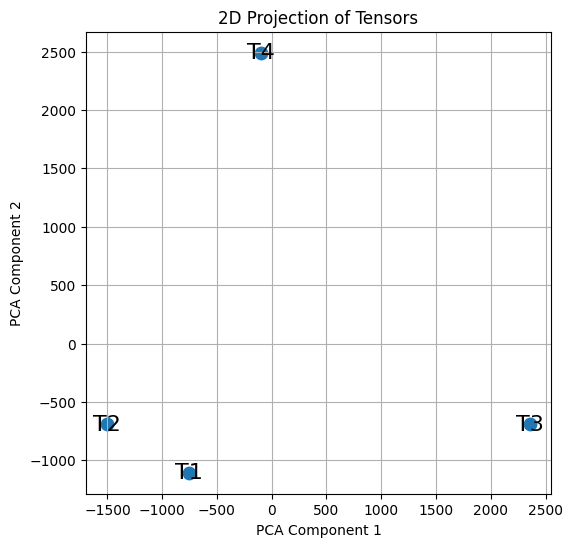

In [30]:
a = torch.randn(128, 256, 256)
b = torch.randn(128, 256, 256)
c = torch.randn(128, 256, 256)
d = torch.randn(128, 256, 256)


plot_tensors_2d(a.numpy(), b.numpy(), c.numpy(), d.numpy())

In [47]:
import torch
from urllib.request import urlopen
from PIL import Image
import timm

# Load an example image
img = Image.open(urlopen(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png"
))

# Load pretrained DINOv3 ViT-S/16 model from timm
model = timm.create_model('vit_small_patch16_dinov3_qkvb.lvd1689m', pretrained=True)
model.eval()

# Create model-specific preprocessing transforms
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

# Preprocess and batchify
x = transforms(img).unsqueeze(0)  # (1, 3, H, W)

# Extract feature embeddings (instead of classification logits)
with torch.no_grad():
    features = model.forward_features(x)  # (1, feature_dim, ...)
    # Often this returns a dict with 'x_norm_clstoken' or similar
    if isinstance(features, dict):
        # DINOv3 ViTs typically store the final CLS token here
        embedding = features.get('x_norm_clstoken') or features.get('x_norm')
    else:
        embedding = features

print("Feature shape:", tuple(embedding.shape))


plot_tensors_2d(embedding.numpy())


Feature shape: (1, 261, 384)


ValueError: n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

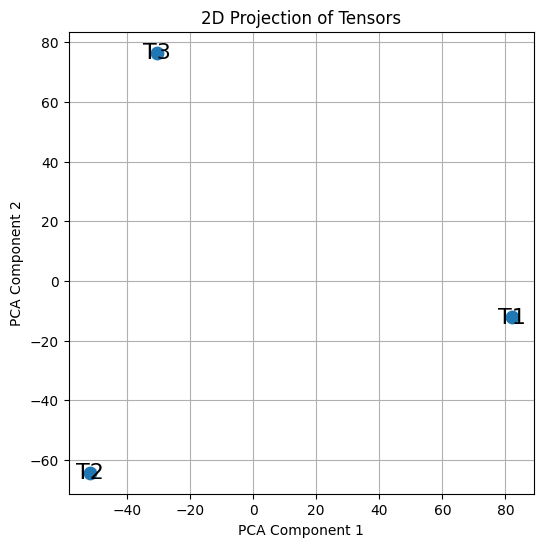

In [52]:
def embed_and_plot(image_urls):
    # Load model
    model = timm.create_model('vit_small_patch16_dinov3_qkvb.lvd1689m', pretrained=True)
    model.eval()

    # Preprocessing
    data_config = timm.data.resolve_model_data_config(model)
    transforms = timm.data.create_transform(**data_config, is_training=False)

    embeddings = []

    for url in image_urls:
        img = Image.open(urlopen(url)).convert("RGB")
        x = transforms(img).unsqueeze(0)

        with torch.no_grad():
            features = model.forward_features(x)
            if isinstance(features, dict):
                embedding = features.get('x_norm_clstoken') or features.get('x_norm')
            else:
                embedding = features

        embeddings.append(embedding.squeeze(0).numpy())

    # Plot if at least two images
    plot_tensors_2d(*embeddings)

# Example usage
image_urls = [
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cropped_bee.jpg",
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/depth2img-tigers.png"
]

embed_and_plot(image_urls)